# RAG Agent (part 2)

We got to point 4 of our checlist:

**1. get a knowledge base: we do that manually, and for this example we use only one document for simplicity.** 

**2. perform OCR of our documents to best extract information;**

**3. embed our documents in a vector database (vector store)**

**4. construct a tool for searching in the database** *<-- we are here* 

**5. create the graph.** 

The idea now is that we could make a single RAG agent with tools, but actually (for the love of the game) we will constructa more robust graph system, drawing inspiration from this LangChain tutorial : [link](https://docs.langchain.com/oss/python/langgraph/agentic-rag#overview).

We will construct a graph that after retrieval checks the relevance of the retrieved documents (grading) and if nothing relevant is found rewrites the query and tries again.

<center>
    <img src="./images/rag.png" width=800>
</center>

We will do this ^ but in a more modern (LangGraph >= 1.0) way.

Let's start by constructing our tool:

## 4. Constructing a Retriever Tool

This is super simple once we already created (see pt. 1) our vector store:

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")  # embeddings have to match!

vector_store = Chroma(
    embedding_function=embedding_function,
    persist_directory="./RAG/chroma"
)

print(vector_store._collection.count())

171


Now we want to construct our graph. Our idea is the following:

<center>
<img src="./images/rag_graph.png" width=400>
</center>
So basically we want to have a router that will either answer the user or route to the actual RAG, if additional context is needed. 

Also, the RAG agent will have its retrieved context graded, and if it passes the grading we generate the answer for the user: otherwise the query is rewritten (max 3 re-routings).

In order to do this we need a custom state first:

In [63]:
from langchain.agents import AgentState
from operator import add
from typing import Annotated

def add_counter(left : int | None, right: int | None) -> int:
    """
    Adds right to left.
    """
    if left is None:
        left = 0
    if right is None:
        right = 0
    return left + right

def list_replace(left : list | None, right : list | None) -> list:
    """
    Replaces left list with right list.
    """
    if left is None:
        return []
    if right is None:
        return []

    return right

class MyState(AgentState):
    # will hold the metadata of the last retrieved documents 
    last_metadata : Annotated[list, list_replace]
    reroute_count : Annotated[int, add_counter]

In [64]:
from langchain_core.messages import ToolMessage
from langchain.tools import tool, ToolRuntime
from langgraph.types import Command

@tool
def retrieve_context(runtime: ToolRuntime, query: str) -> Command:
    """Retrieve information to help answer a query."""
    docs = vector_store.similarity_search(query, k=2)

    serialized = "\n\n".join(
        (f"Source: {doc.metadata['source']}, Page: {doc.metadata['global_page_number']}\nContent: {doc.page_content}")
        for doc in docs
    )

    # add retrieved metadata to state in order to show it to the user later
    last_metadata = [] 
    for doc in docs: 
        last_metadata.append(doc.metadata)  

    return Command(
        update={
            "messages" : [ToolMessage(content=serialized, tool_call_id=runtime.tool_call_id)],
            "last_metadata" : last_metadata
        }
    )

## 5. Create the Graph

first we create a `generate_query_or_respond` node. 

It's a simple llm that decides wwether the answer can be actually answered by retriving context or instead if it's a general answer that doesn't need context retrieval.

In [69]:
from langchain.agents import create_agent, AgentState
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from typing import Literal

class RouterResponse(BaseModel):
    message: str = Field(description="The message to either be displayed to the user or to be displayed to the retriever agent")
    next: str = Field(description="The name of the node to call next: can be one of `retrieve_context` (if the answer needs context retrieval) or 'END' if the answer does not reguard the paper.")

router_llm = ChatOpenAI(model="gpt-4o")
router_agent = create_agent(
    model=router_llm,
    tools=[],
    response_format=RouterResponse,
    system_prompt="""
    You are a helpful assistant that, given a user question, decides wether the answer can be answered by retriving context
    or instead if it's a general answer that doesn't need context retrieval.

    The context that can be retrieved is limited to the scientific paper about the Kimi K2 model from Moonshot AI.
    There is no other context available.

    You answer is composed of two fields:
    - `message`: the message to either be displayed to the user or to be displayed to the retriever agent
    - `next`: the name of the node to call next: can be one of `retrieve` (if the answer needs context retrieval about Kimi K2) or 'END' if the answer does not reguard the paper.
    
    The message to the retriever agent can simply be a concise routing message.
    """
)

def generate_query_or_respond(state: MyState) -> Command[Literal['rag_agent', '__end__']]:
    """
    Decides wether the answer can be actually answered by retriving context or instead if it's a general answer that doesn't need context retrieval.
    """
    response = router_agent.invoke(state)
    structured_response = response['structured_response']

    # routing
    next = structured_response.next
    if next == 'retrieve':
        goto = 'rag_agent'
    else:
        goto = '__end__'

    message = structured_response.message

    return Command(
        update={
            "messages" : [HumanMessage(content=message)]
        },
        goto=goto
    )


This is a just a call to an llm that is given the above tool.

In [83]:
from langchain_core.messages import HumanMessage

retriever_agent = create_agent(
    model=ChatOpenAI(model="gpt-4o"),
    tools=[retrieve_context],
    system_prompt="""
    You are a helpful assistant that can answer questions about a scientific paper, 
    which regards the implementation of the Kimi K2 model from Moonshot AI.
    You can use the retriever tool to retrieve information from the paper.
    """
)

def rag_agent(state: MyState)-> Command[Literal['grade_documents']]:
    """
    Invokes the retriever agent.
    """
    response = retriever_agent.invoke(state)
    # parse out last message and last metadata
    last_msg = response['messages'][-1]
    last_metadata = response['last_metadata'] 

    return Command(
        update={
            "messages": [HumanMessage(content=last_msg.content)],
            "last_metadata" : last_metadata
        }
    )

Add a conditional edge — `grade_documents` — to determine whether the retrieved documents are relevant to the question. We will use a model with a structured output schema `GradeDocuments` for document grading. The `grade_documents` function will return the name of the node to go to based on the grading decision (`generate_answer` or `rewrite_question`):

In [82]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain.chat_models import init_chat_model

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

grader_model = init_chat_model("gpt-4o", temperature=0)

def grade_documents(
    state: MyState,
) -> Command[Literal["generate_answer", "rewrite_question"]]:

    """Determine whether the retrieved documents are relevant to the question."""

    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        goto = "generate_answer"
        reroute = 0  # going to generate answer
        metadata = state.get('last_metadata', [])  # keep the metadata
        if len(metadata) == 0:
            raise RuntimeError("No metadata found")
    else:
        goto = "rewrite_question"
        reroute = 1  # +1 reroute
        metadata = []  # reset metadata, we are retrieving again
        
    return Command(
        update={
            "reroute_count" : reroute,
            "last_metadata" : metadata
        },
        goto=goto
    )

and now we build the `rewrite_question` node. The retriever tool can return potentially irrelevant documents, which indicates a need to improve the original user question. To do so, we will call the `rewrite_question` node:

In [81]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

response_model = init_chat_model("gpt-4o", temperature=0)

def rewrite_question(state: MyState)-> Command[Literal['rag_agent']]:
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return Command(
        update={
            "messages": [HumanMessage(content=response.content)]
        },
        goto='rag_agent'
    )

finally, the `generate_answer` node: if we pass the grader checks, we can generate the final answer based on the original question and the retrieved context:

In [80]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Question: {question} \n"
    "Context: {context}"
)

def generate_answer(state: MyState)-> Command[Literal['__end__']]:
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])

    return Command(
        update={
            "messages": [response]
        },
        goto='__end__'
    )

Now we build the graph:

In [84]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node(rag_agent)
workflow.add_node(grade_documents)
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Compile
graph = workflow.compile()

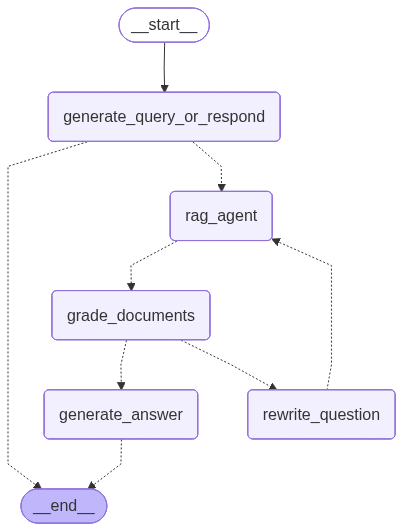

In [85]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
input_msg = HumanMessage("What are the new ideas in the implementation of the KimiK2 model?")